In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import regularizers
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix






## Hiperparametros

In [13]:
batch_size = 32
epochs = 100
IMG_HEIGHT = 20
IMG_WIDTH = 20
TRAIN_DIR = "training_data"
SEED = 123  # Semilla fija para asegurar que el split sea igual en ambos generadores

## Generador de datos

In [14]:
# Generador para ENTRENAMIENTO (Con Aumento de Datos + Normalización simple)
train_datagen = ImageDataGenerator(
    rescale=1./255,          # <--- CAMBIO CLAVE: Normalización estándar 0-1
    rotation_range=10,       # Reduje un poco la rotación para digitos 20x20
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    shear_range=0.1,
    validation_split=0.2     # Reservamos 20%
)

# Generador para VALIDACIÓN (Solo Normalización simple, SIN aumento)
val_datagen = ImageDataGenerator(
    rescale=1./255,          # <--- Debe coincidir con train
    validation_split=0.2     # Reservamos 20%
)

# 3. CREACIÓN DE LOS FLUJOS (FLOWS)

# Flujo de Entrenamiento (toma el 80%)
train_data_gen = train_datagen.flow_from_directory(
    directory=TRAIN_DIR,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=batch_size,
    color_mode="grayscale",
    class_mode="categorical",
    subset='training',       # <--- IMPORTANTE: Solo datos de train
    shuffle=True,
    seed=SEED
)

# Flujo de Validación (toma el 20%)
val_data_gen = val_datagen.flow_from_directory(
    directory=TRAIN_DIR,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=batch_size,
    color_mode="grayscale",
    class_mode="categorical",
    subset='validation',     # <--- IMPORTANTE: Solo datos de validación
    shuffle=True,
    seed=SEED                # Misma seed para asegurar que no se mezclen
)


Found 10173 images belonging to 9 classes.
Found 2538 images belonging to 9 classes.


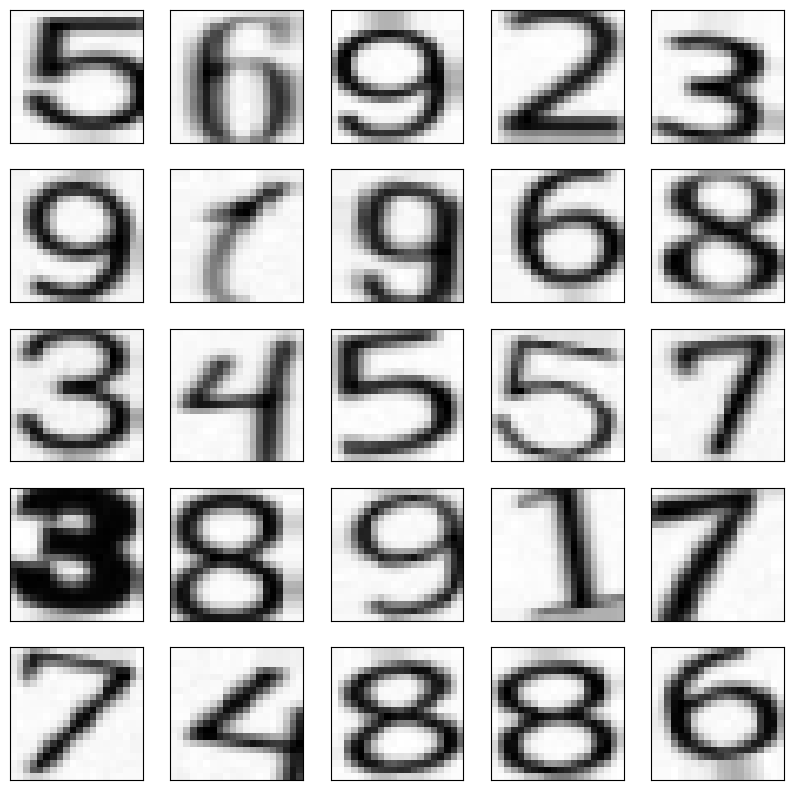

In [17]:
sample_training_images, _ = next(train_data_gen)

plt.figure(figsize=(10,10))
for i in range(25):
  plt.subplot(5,5,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(sample_training_images[i], cmap='gray')


## Modelo

In [18]:
# 4. ARQUITECTURA DEL MODELO
model = Sequential([
    # Capa 1
    Conv2D(16, 3, padding='same', activation='relu',
           kernel_regularizer=regularizers.l2(0.0001),
           input_shape=(IMG_HEIGHT, IMG_WIDTH , 1)),
    MaxPooling2D(),
    Dropout(0.2),

    # Capa 2 (Añadida opcionalmente para estabilidad, si quieres la puedes quitar)
    # Conv2D(32, 3, padding='same', activation='relu'),
    # MaxPooling2D(),

    Flatten(),

    # Densa
    Dense(50, activation='relu', kernel_regularizer=regularizers.l2(0.0001)),
    Dropout(0.2),

    # Salida
    Dense(9, activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

/Users/faustogabini/Documents/projects/sudoku-solver/venv/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

# 5. ENTRENAMIENTO
history = model.fit(
    train_data_gen,
    steps_per_epoch=train_data_gen.samples // batch_size,
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=val_data_gen.samples // batch_size,
)


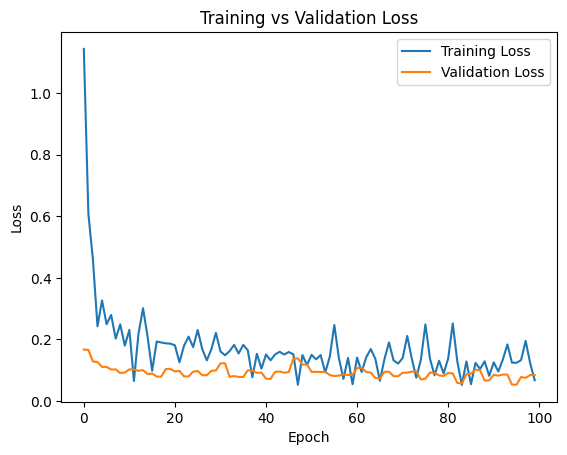

In [ ]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training vs Validation Loss')
plt.show()


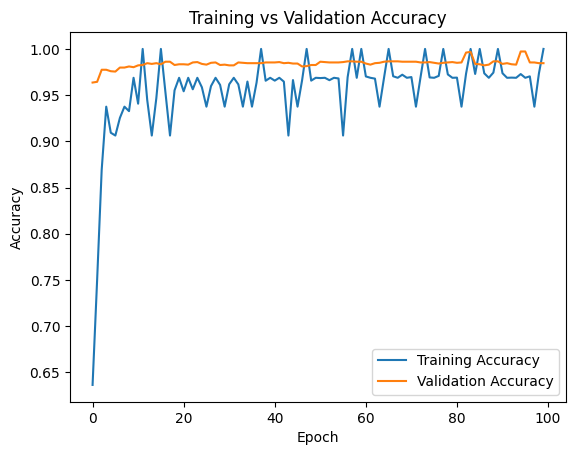

In [ ]:
plt.figure()
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training vs Validation Accuracy')
plt.show()


In [ ]:
model.save("trained.keras")

In [19]:
TEST_DIR = "testing_data"

In [21]:
model = load_model("trained.keras")

In [22]:

test_image_gen = ImageDataGenerator(rescale=1./255)

test_data_gen = test_image_gen.flow_from_directory(
    directory=TEST_DIR,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    color_mode="grayscale",
    class_mode="categorical",
    shuffle=False,          # clave para evaluar bien
    batch_size=batch_size
)

Found 1471 images belonging to 9 classes.


Generando predicciones...


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
Mapeo de clases: {'1': 0, '2': 1, '3': 2, '4': 3, '5': 4, '6': 5, '7': 6, '8': 7, '9': 8}


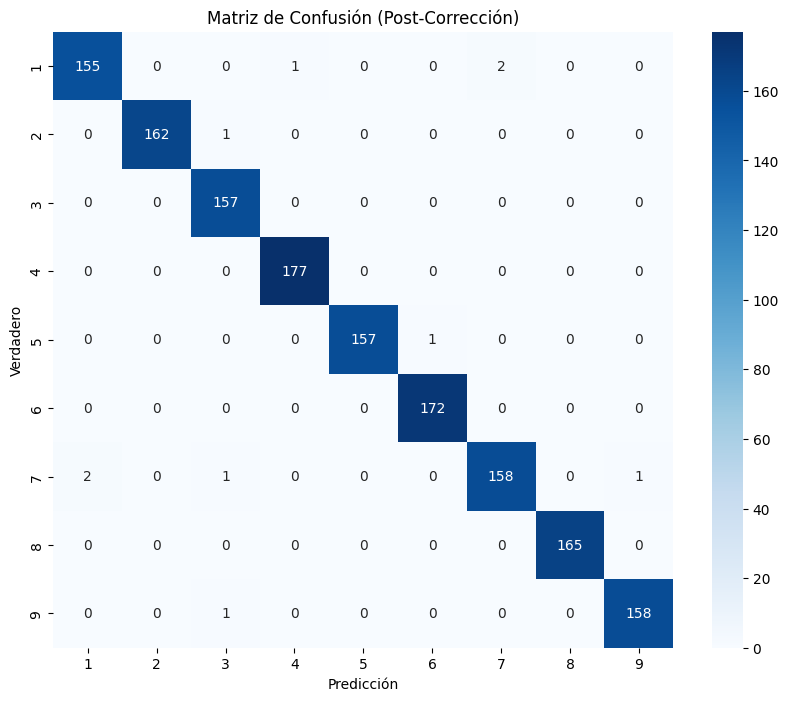


Reporte de Clasificación:
              precision    recall  f1-score   support

           1       0.99      0.98      0.98       158
           2       1.00      0.99      1.00       163
           3       0.98      1.00      0.99       157
           4       0.99      1.00      1.00       177
           5       1.00      0.99      1.00       158
           6       0.99      1.00      1.00       172
           7       0.99      0.98      0.98       162
           8       1.00      1.00      1.00       165
           9       0.99      0.99      0.99       159

    accuracy                           0.99      1471
   macro avg       0.99      0.99      0.99      1471
weighted avg       0.99      0.99      0.99      1471



In [ ]:

# Obtener predicciones
print("Generando predicciones...")
predictions = model.predict(test_data_gen)
y_pred = np.argmax(predictions, axis=1) # Convertimos probabilidades a etiquetas (0, 1, 2...)
y_true = test_data_gen.classes          # Etiquetas reales

# Mapeo de clases
class_labels = list(test_data_gen.class_indices.keys())
print("Mapeo de clases:", test_data_gen.class_indices)

# Generar y visualizar la Matriz de Confusión
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)
plt.ylabel('Verdadero')
plt.xlabel('Predicción')
plt.title('Matriz de Confusión (Post-Corrección)')
plt.show()

print("\nReporte de Clasificación:")
print(classification_report(y_true, y_pred, target_names=class_labels))